In [1]:
from google.colab import files

print(f"{'*'*27}\n* Upload Kaggle.json file *\n{'*'*27}")
kaggle_json = files.upload()

***************************
* Upload Kaggle.json file *
***************************


Saving kaggle.json to kaggle.json


In [2]:
%%capture
!pip install opendatasets

In [3]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/chrisfilo/urbansound8k'
od.download(dataset_url)

100%|██████████| 5.61G/5.61G [03:55<00:00, 25.5MB/s]


In [4]:
%%capture
!pip install librosa

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

import IPython.display as ipd
import librosa
import librosa.display
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import random

In [6]:
all_audio_files = glob.glob("/content/urbansound8k/*/*.wav")
print(f"Total Audio Files: {len(all_audio_files)}")
print(f"Sampel file: {all_audio_files[0]}")

Total Audio Files: 8732
Sampel file: /content/urbansound8k/fold8/55013-3-0-1.wav


In [7]:
filename = all_audio_files[0]
data, sample_rate=librosa.load(filename)
print(f"data shape: {data.shape}\ndata sample: {data[:3]}...")
print(f"sample rate: {sample_rate}")
ipd.Audio(filename)

data shape: (88200,)
data sample: [0.00230569 0.00319139 0.00233925]...
sample rate: 22050


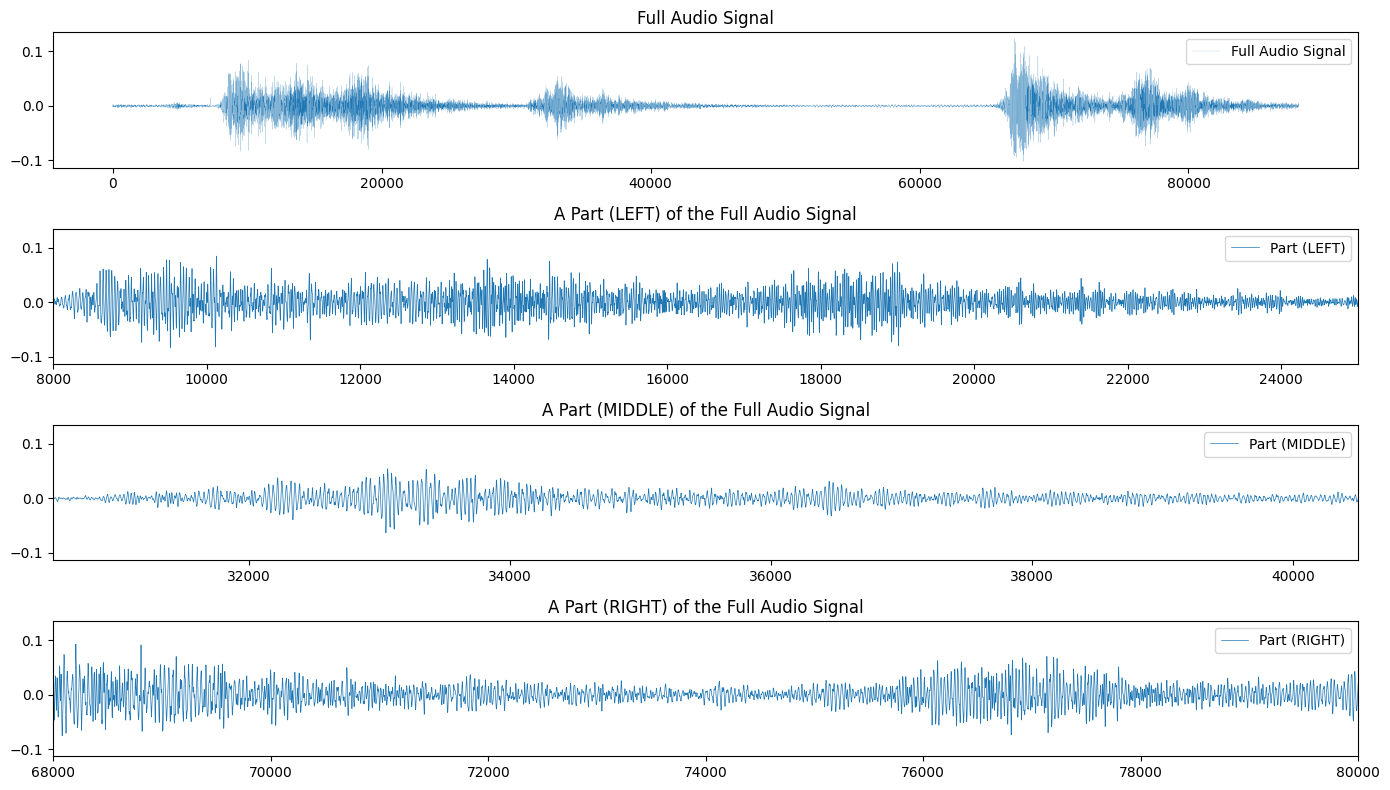

In [28]:
# Plot the first subplot
plt.subplot(4, 1, 1)
pd.Series(data).plot(figsize=(14,8), lw=0.1, label='Full Audio Signal')
plt.title('Full Audio Signal')
plt.legend()

# Plot the second subplot
plt.subplot(4, 1, 2)
pd.Series(data).plot(figsize=(14,8), lw=0.5, label='Part (LEFT)')
plt.xlim(8000, 25000)
plt.title('A Part (LEFT) of the Full Audio Signal')
plt.legend()

# Plot the third subplot
plt.subplot(4, 1, 3)
pd.Series(data).plot(figsize=(14,8), lw=0.5, label='Part (MIDDLE)')
plt.xlim(30500, 40500)
plt.title('A Part (MIDDLE) of the Full Audio Signal')
plt.legend()

# Plot the fourth subplot
plt.subplot(4, 1, 4)
pd.Series(data).plot(figsize=(14,8), lw=0.5, label='Part (RIGHT)')
plt.xlim(68000, 80000)
plt.title('A Part (RIGHT) of the Full Audio Signal')
plt.legend()

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined figure
plt.show()

In [11]:
metadata = pd.read_csv('/content/urbansound8k/UrbanSound8K.csv')
metadata.sample(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
4202,180125-4-3-10.wav,180125,120.566321,124.566321,1,5,4,drilling
2057,148837-6-2-0.wav,148837,2.959783,4.424286,1,4,6,gun_shot
1070,124389-8-1-7.wav,124389,199.413986,203.413986,2,6,8,siren
8422,9223-2-0-10.wav,9223,5.000000,9.000000,1,3,2,children_playing
1416,135160-8-0-6.wav,135160,126.307227,130.307227,2,6,8,siren


In [40]:
file_paths = []
for idx in tqdm(range(len(metadata))):
    # "/content/urbansound8k/fold" + str(fold) + "/" + slice_file_name
    slice_file_name = metadata.iloc[idx, 0]
    fold = metadata.iloc[idx, 5]
    full_path = "/content/urbansound8k/fold" + str(fold) + "/" + slice_file_name
    file_paths.append(full_path)

metadata['full_path'] = file_paths
metadata.sample(5)

100%|██████████| 8732/8732 [00:00<00:00, 15090.44it/s]


,slice_file_name,fsID,start,end,salience,fold,classID,class,full_path
806,115415-9-0-6.wav,115415,3.599702,7.599702,2,4,9,street_music,/content/urbansound8k/fold4/115415-9-0-6.wav
2116,151149-2-0-3.wav,151149,1.500000,5.500000,2,3,2,children_playing,/content/urbansound8k/fold3/151149-2-0-3.wav
7296,66623-4-0-6.wav,66623,3.000000,7.000000,1,6,4,drilling,/content/urbansound8k/fold6/66623-4-0-6.wav
8323,86284-3-0-0.wav,86284,17.911702,21.911702,2,5,3,dog_bark,/content/urbansound8k/fold5/86284-3-0-0.wav
7477,71866-9-0-31.wav,71866,15.500000,19.500000,1,7,9,street_music,/content/urbansound8k/fold7/71866-9-0-31.wav


In [49]:
# play the audio of a random file
_idx = random.randint(0, len(metadata))
filename = metadata.iloc[_idx, -1]
data, sample_rate=librosa.load(filename)
print(f"data shape: {data.shape}\ndata sample: {data[:3]}...")
print(f"sample rate: {sample_rate}")
print(f"class: {metadata.iloc[_idx, -2]}")
ipd.Audio(filename)

data shape: (88200,)
data sample: [0.01696983 0.02483502 0.02218488]...
sample rate: 22050
class: jackhammer


In [12]:
### Check whether the dataset is imbalanced
metadata['class'].value_counts()

dog_bark            1000
children_playing    1000
air_conditioner     1000
street_music        1000
engine_idling       1000
jackhammer          1000
drilling            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

# Feature Extraction Using MFCC

In [62]:
def feature_extractor(file):
    raw_audio, sample_rate = librosa.load(file)
    # raw_audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    mfccs_features = librosa.feature.mfcc(y=raw_audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    return mfccs_scaled_features

In [63]:
metadata['mfcc_feature'] = metadata['full_path'].apply(feature_extractor)
metadata.sample(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class,full_path,mfcc_feature
340,104998-7-18-3.wav,104998,496.891651,500.891651,1,5,7,jackhammer,/content/urbansound8k/fold5/104998-7-18-3.wav,"[-132.62808, -3.2972183, -19.078491, 21.039352..."
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing,/content/urbansound8k/fold5/100263-2-0-143.wav,"[-441.0859, 108.92061, -25.777704, 47.518364, ..."
2132,151977-0-0-2.wav,151977,1.466587,5.466587,1,1,0,air_conditioner,/content/urbansound8k/fold1/151977-0-0-2.wav,"[-303.7514, 131.56511, -4.546284, 20.75766, 1...."
289,104625-4-0-52.wav,104625,32.251409,36.251409,1,7,4,drilling,/content/urbansound8k/fold7/104625-4-0-52.wav,"[-93.95017, 58.65119, -37.1668, 22.236101, -10..."
8725,99812-1-0-2.wav,99812,39.176254,43.176254,2,7,1,car_horn,/content/urbansound8k/fold7/99812-1-0-2.wav,"[-351.60995, 87.59203, -39.39027, 39.02892, 5...."


In [64]:
extracted_features = metadata.iloc[:, [-1, -3]]
extracted_features

,mfcc_feature,class
0,"[-211.93698, 62.581215, -122.813156, -60.74529...",dog_bark
1,"[-417.0052, 99.336624, -42.995586, 51.073326, ...",children_playing
2,"[-452.39316, 112.36253, -37.578075, 43.195866,...",children_playing
3,"[-406.47922, 91.1966, -25.043556, 42.78452, 11...",children_playing
4,"[-439.63873, 103.86223, -42.658787, 50.690285,...",children_playing
...,...,...
8727,"[-391.3721, 125.36239, -40.634056, 25.899754, ...",car_horn
8728,"[-339.42715, 76.409096, -35.30988, 41.984035, ...",car_horn
8729,"[-297.31534, 102.09026, -36.75108, 26.816488, ...",car_horn
8730,"[-336.92386, 115.3139, -44.84709, 24.968985, -...",car_horn


In [65]:
X = np.array(extracted_features['mfcc_feature'].tolist())
y = np.array(extracted_features['class'].tolist())

X.shape, y.shape

((8732, 40), (8732,))

In [66]:
y = np.array(pd.get_dummies(y))
y.shape

(8732, 10)

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6985, 40), (1747, 40), (6985, 10), (1747, 10))